In [69]:
import time
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['grid.color'] = (.7, .7, .7, 0)
plt.rcParams['figure.figsize'] = (16, 10)

Links included in the evaluation, i.e. the first 32 links of 4A in the CCW direction:

In [70]:
links = ['1277:1102', '10427:1183', '2675:1188', '1188:1190', '1190:1192',
         '1192:1193', '29848:1254', '1254:1255', '10116:1258', '1258:1260',
         '1260:1261', '1261:1262', '1990:1268', '1268:1269', '1269:1270',
         '1270:1272', '1272:1273', '1273:1274', '1274:1275', '1275:1276',
         '1276:1277', '10017:1989', '1989:1990', '1193:2666', '1183:2673',
         '2673:2675', '7035:2757', '1262:7035', '2757:10017', '1255:10115',
         '10115:10116', '1102:10427']
len(links)

32

In [71]:
dates = pd.date_range('2017-10-10', '2017-10-14')

In [72]:
cms = []

for d in dates:
    cm = pd.read_csv('../data/current_model/estimated-link-travel-time_' + d.strftime('%Y%m%d') + '.csv', 
                     names = ['LogTime', 
                              'JourneyRef',
                              'JourneyLinkRef',
                              'VehicleRef', 
                              'LinkRef',
                              'EstimatedDepartureDateTime', 
                              'EstimatedArrivalDateTime',
                              'EstimatedLinkTravelTime', 
                              'EstimateAge'])

    cm['LogTime'] = pd.to_datetime(cm['LogTime'])
    cm['EstimatedDepartureDateTime'] = pd.to_datetime(cm['EstimatedDepartureDateTime'])
    cm['EstimatedArrivalDateTime'] = pd.to_datetime(cm['EstimatedArrivalDateTime'])
    cm = cm[cm['LinkRef'].isin(links)]
    
    cms.append(cm)

cm = pd.concat(cms)

In [73]:
len(cm['LinkRef'].unique())

32

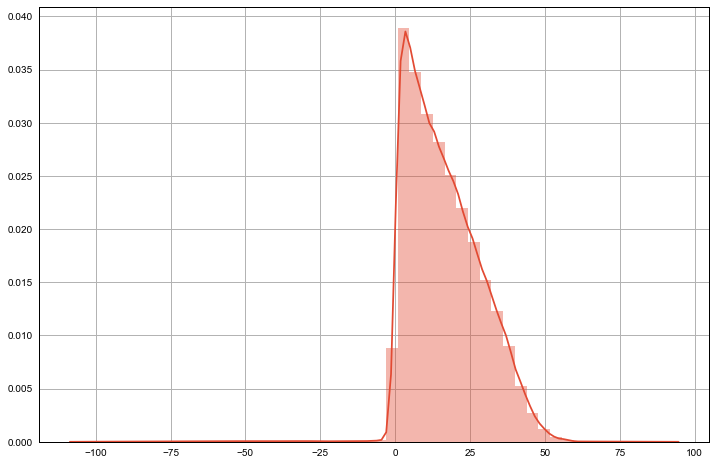

In [74]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.distplot((cm[cm['EstimatedDepartureDateTime'].notnull()]['EstimatedDepartureDateTime'] - cm[cm['EstimatedDepartureDateTime'].notnull()]['LogTime']) / np.timedelta64(1, 'm'))

In [75]:
diff = cm['EstimatedDepartureDateTime'] - cm['LogTime']
cm.loc[diff >= pd.to_timedelta('00:45:00'), 'Prediction'] = '45min+'
cm.loc[(pd.to_timedelta('00:30:00') <= diff) & (diff < pd.to_timedelta('00:45:00')), 'Prediction'] = '45min'
cm.loc[(pd.to_timedelta('00:15:00') <= diff) & (diff < pd.to_timedelta('00:30:00')), 'Prediction'] = '30min'
cm.loc[(pd.to_timedelta('00:00:00') <= diff) & (diff < pd.to_timedelta('00:15:00')), 'Prediction'] = '15min'
cm_15min = cm[cm['Prediction'] == '15min']

In [76]:
len(cm_15min['LinkRef'].unique())

32

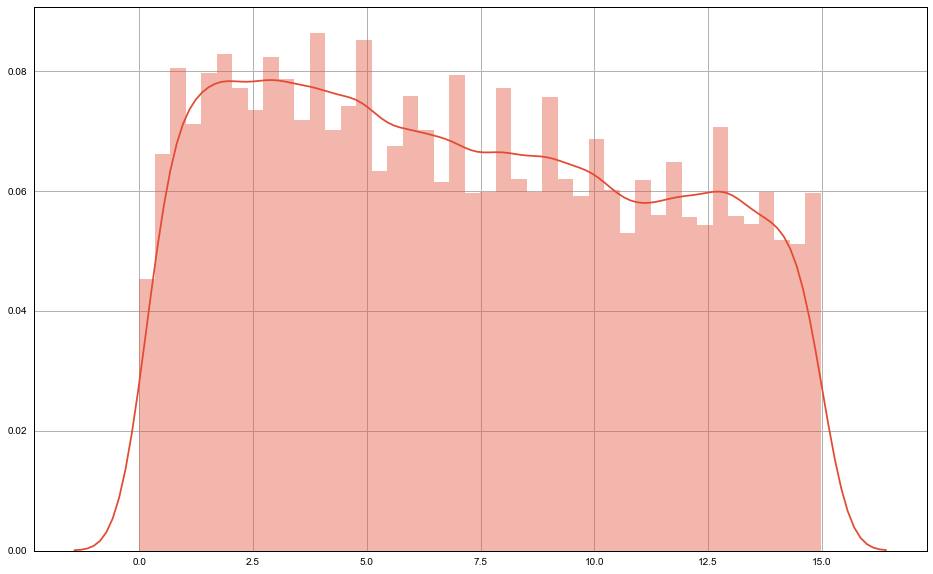

In [77]:
sns.distplot((cm_15min[cm_15min['EstimatedDepartureDateTime'].notnull()]['EstimatedDepartureDateTime'] - cm_15min[cm_15min['EstimatedDepartureDateTime'].notnull()]['LogTime']) / np.timedelta64(1, 'm'))

In [78]:
tss = {}
for link_ref, measures in cm_15min.groupby('LinkRef'):
    measures = measures.set_index('LogTime')
    tss[link_ref] = measures.resample('15min')['EstimatedLinkTravelTime'].mean() 

ts = pd.DataFrame(tss)

In [79]:
ts.shape

(479, 32)

In [80]:
ts_wo_missing = ts.interpolate().fillna(method = 'pad').fillna(method='bfill')

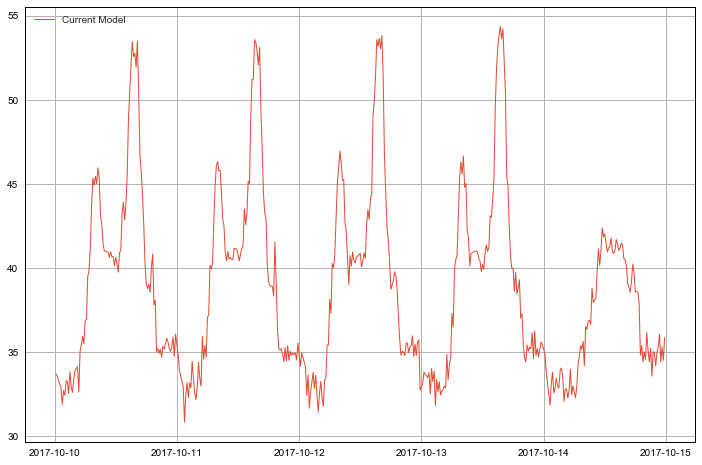

In [81]:
fig, ax = plt.subplots(figsize = (12, 8))
plt.plot(ts_wo_missing.sum(axis = 1) / 60, label = 'Current Model', linewidth = 1)
ax.legend(loc='upper left')

In [82]:
ts_wo_missing.to_csv('../data/current_model/data_prepared.csv')